#Power
* Startdate - datetime on an hourly frequency
* Value (kWh) - Power consumption on a hourly consumption
* day_of_week - day of the week(0 - Monday to 6 - Sunday)
* notes - categorical column (weekend, weeday, COVID-lockdown and vacation)

#Weather
* Date - dates with daily frequency
* Day - day of the month
* day_of_week - day of week (0 - Monday to 6 - Sunday)
* Temp(max/avg/min) - min/avgmin temperature on daily basis (℉)
* Press(max/avg/min) - min/avgmin pressure on daily basis (P)
* Wind(max/avg/min) - min/avgmin wind speed on daily basis (km/h)
* Hum(max/avg/min) - min/avgmin humidity on daily basis
* Dew(max/avg/min) - min/avgmin dew on daily basis


#***Mounting to Google Drive***

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cp -r '/content/drive/MyDrive/Data Analytics/AI ML/Helper_Functions' /content

cp: cannot open '/content/drive/MyDrive/Data Analytics/AI ML/Helper_Functions/README.md.gdoc' for reading: Operation not supported


#***Installing Packages***

In [3]:
!pip install -q pmdarima

     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 9.8 MB 43.1 MB/s 


In [4]:
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 8.8 MB/s 


#***Importing Packages***

In [6]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels as sm
import matplotlib
import math

In [7]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import mean_squared_error, mean_absolute_error
from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [9]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.compat.pandas import Appender
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

In [41]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import HyperModel,RandomSearch

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [12]:
from Helper_Functions import common_utils as cu
from Helper_Functions import timeseries_utils as tu
from Helper_Functions import regression_utils as ru

#***Reading CSV File***

In [62]:
power = pd.read_csv('/content/drive/MyDrive/Data Analytics/AI ML/Time Series/Power Consumption/power_usage_2016_to_2020.csv')
weather = pd.read_csv('/content/drive/MyDrive/Data Analytics/AI ML/Time Series/Power Consumption/weather_2016_2020_daily.csv')

In [63]:
power.head()

,StartDate,Value (kWh),day_of_week,notes
0,06-01-2016 00:00,1.057,2,weekday
1,06-01-2016 01:00,1.171,2,weekday
2,06-01-2016 02:00,0.560,2,weekday
3,06-01-2016 03:00,0.828,2,weekday
4,06-01-2016 04:00,0.932,2,weekday


In [64]:
weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


##**Merging the Two CSV Files**

**Since the weather dataset has a Daily frequency, we aggregate the power dataset also into daily frequency dataset**

In [65]:
# Date column update for 'power'
n = power.shape[0]
p1 = pd.Series(range(n), pd.period_range('2016-06-01 00:00:00', freq = '1H', periods = n))
power['StartDate'] = p1.to_frame().index

In [66]:
# Date column update for 'weather'
m = weather.shape[0]
p2 = pd.Series(range(m), pd.period_range('2016-06-01', freq = '1D', periods = m))
weather['Date'] = p2.to_frame().index

In [67]:
# convert the period date into timestamp
power['StartDate'] = power['StartDate'].apply (lambda x: x.to_timestamp())
power['Date'] = pd.DatetimeIndex(power['StartDate']).date

weather['Date'] = weather['Date'].apply (lambda x: x.to_timestamp())

In [68]:
# The day_of_week column had an issue in the ordering, hence creating a new one using datetime object
power['Date'] = pd.to_datetime(power['Date'])
power['DOW'] = power['Date'].dt.dayofweek

In [69]:
# Aggregating hourly frequency into daily 
df_power_daily = power.groupby('Date').sum()
df_power_daily['DOW'] = df_power_daily['DOW'].apply(lambda x: x/24)

notes_col = power.groupby('Date').first()['notes'].values
df_power_daily['notes'] = notes_col

In [70]:
#filter the weather data to match with power usage dataframe. 
k = df_power_daily.shape[0]
df_weather = weather[0:k]
df_weather.set_index('Date', inplace=True)

In [71]:
# Merging the 2 datasets after all the cleaning up
comb_df = pd.merge(df_weather,df_power_daily,left_index=True, right_index=True)
comb_df.columns

Index(['Day', 'Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg',
       'Dew_min', 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg',
       'Wind_min', 'Press_max', 'Press_avg', 'Press_min', 'Precipit',
       'day_of_week_x', 'Value (kWh)', 'day_of_week_y', 'DOW', 'notes'],
      dtype='object')

In [72]:
# Dropping the day_of_week columns since the are in the wrong order, hence useless
comb_df.drop(columns= ['day_of_week_x', 'day_of_week_y'], 
             inplace=True)
comb_df.index.freq = 'D'

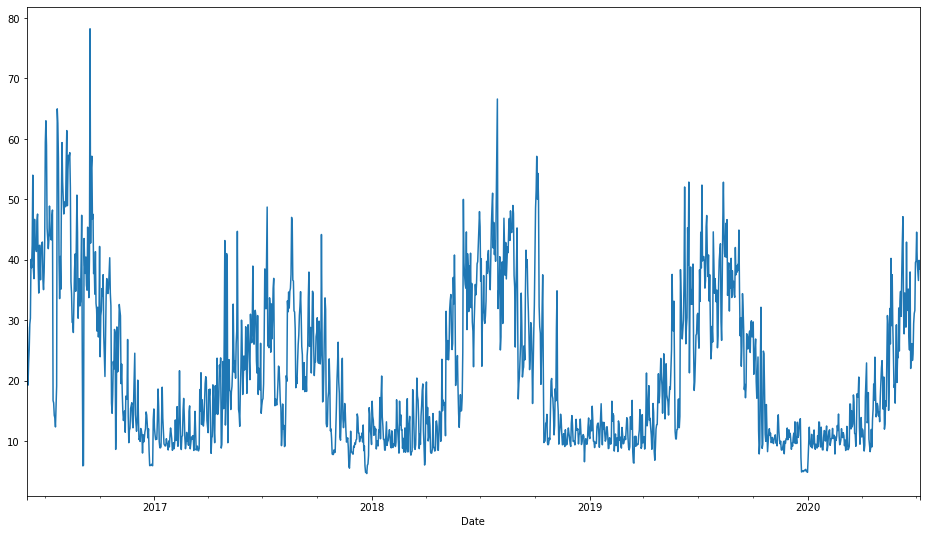

In [73]:
comb_df['Value (kWh)'].plot(figsize=(16,9))

#***Common Preprocessing***

##**OneHot Encoding**

In [74]:
# Apply one hot encoding to the notes column
comb_df = pd.get_dummies(comb_df, columns=["notes"], prefix='', prefix_sep='')  # drop_first

Why 4 column??

##**Correlation Plotting**

In [75]:
cu.column_correlation_importance(comb_df, 'Value (kWh)')

Value (kWh)       1.000000
Temp_avg          0.720178
Temp_max          0.710673
Temp_min          0.705234
Dew_min           0.645126
Dew_avg           0.634184
Dew_max           0.606610
Press_max         0.385739
Press_avg         0.291159
Wind_avg          0.209835
vacation          0.160098
Wind_min          0.136839
Hum_max           0.100471
Hum_min           0.075223
weekend           0.068429
Day               0.058705
Wind_max          0.049319
DOW               0.046027
Press_min         0.044568
Precipit          0.029940
Hum_avg           0.022245
COVID_lockdown    0.016443
weekday           0.007316
Name: Value (kWh), dtype: float64


##**Dropping Columns(Based on Correlation Plotting)**

* Since the columns like temp, press, wind, humid and dew have 3 columns with similar values and correlation value, we only use Avg values since they have an higher correlation value on average.
* Columns like the binary(one-hot encoded columns), DOW, Day and precipit have very low correlation value and hence we drop them

In [76]:
comb_df.drop(columns= ['Temp_max', 'Temp_min','Dew_max','Dew_min', 'Hum_avg', 'Hum_min', 'Wind_max','Wind_min','Press_avg', 'Press_min', 'Precipit', 'Day', 'DOW', 'weekend', 'weekday', 'COVID_lockdown', 'vacation'], inplace=True)

In [77]:
comb_df.head()

,Temp_avg,Dew_avg,Hum_max,Wind_avg,Press_max,Value (kWh)
Date,,,,,,
2016-06-01,74.8,71.4,100,9.5,29.8,29.691
2016-06-02,71.2,70.3,100,7.8,29.8,28.789
2016-06-03,72.1,70.0,100,4.7,29.8,19.247
2016-06-04,71.2,70.0,100,7.0,29.8,22.883
2016-06-05,73.8,70.0,100,7.7,29.7,25.195


#***LSTM***

##Pre-Processing

**Since we are using LSTM model here, which is a Multivariate model we will be using multiple feature columns and hence we need to scale them down first**

In [29]:
col_list = ['Temp_avg', 'Dew_avg', 'Wind_avg', 'Press_max', 'Hum_max']

**Based on the skewness of each column(scatter plot of each column), we decide whether to go for Normalization or Min-Max Scaling**

In [30]:
scale_list, normalise_list = cu.preprocess_numeric_column_data(comb_df[col_list])
print(scale_list)
print(normalise_list)

[]
['Temp_avg', 'Dew_avg', 'Wind_avg', 'Press_max', 'Hum_max']


**We can see that all the data needs to be normalized, meaning all of the data is skewed**

In [31]:
if len(normalise_list) > 0:
  cu.normalization(comb_df, normalise_list)
if len(scale_list) > 0:
  cu.standardization(comb_df, scale_list)

##Splitting the Data

In [32]:
comb_df

,Temp_avg,Dew_avg,Hum_max,Wind_avg,Press_max,Value (kWh)
Date,,,,,,
2016-06-01,0.053476,0.278061,0.6,0.578947,-0.5,29.691
2016-06-02,-0.139037,0.221939,0.6,0.131579,-0.5,28.789
2016-06-03,-0.090909,0.206633,0.6,-0.684211,-0.5,19.247
2016-06-04,-0.139037,0.206633,0.6,-0.078947,-0.5,22.883
2016-06-05,0.000000,0.206633,0.6,0.105263,-1.0,25.195
...,...,...,...,...,...,...
2020-07-03,0.582888,0.349490,-0.3,-0.263158,0.0,39.659
2020-07-04,0.577540,0.354592,0.0,-0.973684,0.0,38.071
2020-07-05,0.620321,0.385204,-0.6,-0.289474,-0.5,36.565


For LSTM, we split data differently
* The data is divided into windows of size n(n = no. of columns + 1) as input X and output y
  * Each windows will have an n arrays, where each array will contain a row of data and y will have Power value of the next row
  * Ex: The 1st window will have first 7(6+1) rows of data [2016/06/01 - 2016/06/07] and 2nd window will have the 7 rows starting from 2nd row [2016/06/02 - 2016/06/08] and so on.
  * The y will contain the data of the 8th row of the label feature
* Overall, the shape of one input and output will be X - [7,6] , Y - [1]

In [33]:
X, y = tu.df_to_x_y(comb_df, 5, (len(comb_df.columns)+1))
X.shape, y.shape

((1491, 7, 6), (1491,))

In [36]:
X[0]

array([[ 0.05347594,  0.27806122,  0.6       ,  0.57894737, -0.5       ,
        29.691     ],
       [-0.13903743,  0.22193878,  0.6       ,  0.13157895, -0.5       ,
        28.789     ],
       [-0.09090909,  0.20663265,  0.6       , -0.68421053, -0.5       ,
        19.247     ],
       [-0.13903743,  0.20663265,  0.6       , -0.07894737, -0.5       ,
        22.883     ],
       [ 0.        ,  0.20663265,  0.6       ,  0.10526316, -1.        ,
        25.195     ],
       [ 0.14973262,  0.24744898,  0.6       , -0.68421053, -1.        ,
        29.323     ],
       [ 0.31016043,  0.21683673,  0.6       , -0.60526316, -0.5       ,
        30.322     ]])

In [39]:
y[0]

40.051

In [34]:
X_train, y_train, X_valid, y_valid, X_test, y_test = tu.split_train_test_LSTM(X, y, 0.2, 0.1)

##Hyperparameter Tuning

**Since, LSTM is a Deep Learning model, we use Keras_tuner for hyperparameter tuning**

In a basic LSTM model, we have 4 layers, with 1 input, 2 hidden and 1 output layer.
* Input and Output layer will have fixed inputs, hence we try to find the best node values for the hidden layers
* Another parameter we can try to find the optimum value is learning rate

In [42]:
def build_model(hp):
  model = Sequential()
  model.add(InputLayer((7,6)))
  model.add(LSTM(units = hp.Int('unitsLSTM', min_value = 32, max_value = 512, step = 64)))
  model.add(Dense(units = hp.Int('unitsDense', 16, 128, 16), activation = 'relu'))
  model.add(Dense(1, 'linear'))

  model.compile(loss=MeanSquaredError(), 
                optimizer=Adam(hp.Choice('learning_rate', [0.0001,0.01])),    # learning_rate=0.0001
                metrics=[RootMeanSquaredError()])
  return model

In [43]:
tuner = RandomSearch(
    build_model,
    kt.Objective("val_root_mean_squared_error", direction="min"),
    max_trials = 20,
    directory = 'my_dir',
    project_name = 'LSTM',
    overwrite = True)

Summary below shows the summary of all parameters we are trying to find the optimum value of and the range of each of them

In [44]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
unitsLSTM (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 64, 'sampling': None}
unitsDense (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.01], 'ordered': True}


In [45]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [46]:
tuner.search(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid), callbacks=[stop_early])

Trial 20 Complete [00h 00m 22s]
val_root_mean_squared_error: 5.021915435791016

Best val_root_mean_squared_error So Far: 4.872224807739258
Total elapsed time: 00h 09m 22s
INFO:tensorflow:Oracle triggered exit


In [47]:
tuner.results_summary()

Results summary
Results in my_dir/LSTM
Showing 10 best trials
Trial summary
Hyperparameters:
unitsLSTM: 32
unitsDense: 112
learning_rate: 0.01
Score: 4.872224807739258
Trial summary
Hyperparameters:
unitsLSTM: 224
unitsDense: 112
learning_rate: 0.01
Score: 4.923869609832764
Trial summary
Hyperparameters:
unitsLSTM: 480
unitsDense: 96
learning_rate: 0.0001
Score: 4.946192741394043
Trial summary
Hyperparameters:
unitsLSTM: 480
unitsDense: 64
learning_rate: 0.0001
Score: 4.946380615234375
Trial summary
Hyperparameters:
unitsLSTM: 416
unitsDense: 96
learning_rate: 0.0001
Score: 4.966165542602539
Trial summary
Hyperparameters:
unitsLSTM: 480
unitsDense: 32
learning_rate: 0.0001
Score: 4.969633102416992
Trial summary
Hyperparameters:
unitsLSTM: 416
unitsDense: 32
learning_rate: 0.0001
Score: 4.982413291931152
Trial summary
Hyperparameters:
unitsLSTM: 352
unitsDense: 48
learning_rate: 0.0001
Score: 5.001215934753418
Trial summary
Hyperparameters:
unitsLSTM: 224
unitsDense: 80
learning_rate: 0

###The above result sumary gives us 6 different values which corresponds to the top 3 and worst 3 combination of parameters for the model

##Defining and Fitting the Model

In [48]:
model = Sequential()
model.add(InputLayer((7,6)))
model.add(LSTM(32))
model.add(Dense(112, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4992      
                                                                 
 dense_2 (Dense)             (None, 112)               3696      
                                                                 
 dense_3 (Dense)             (None, 1)                 113       
                                                                 
Total params: 8,801
Trainable params: 8,801
Non-trainable params: 0
_________________________________________________________________


In [49]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [50]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, callbacks=[cp])

Epoch 1/10
23/33 [===================>..........] - ETA: 0s - loss: 291.0243 - root_mean_squared_error: 17.0594

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


33/33 [==============================] - 7s 155ms/step - loss: 238.6829 - root_mean_squared_error: 15.4494 - val_loss: 40.6408 - val_root_mean_squared_error: 6.3750
Epoch 2/10
23/33 [===================>..........] - ETA: 0s - loss: 38.5539 - root_mean_squared_error: 6.2092

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


33/33 [==============================] - 4s 130ms/step - loss: 37.8840 - root_mean_squared_error: 6.1550 - val_loss: 26.9043 - val_root_mean_squared_error: 5.1869
Epoch 3/10
33/33 [==============================] - 0s 6ms/step - loss: 34.6723 - root_mean_squared_error: 5.8883 - val_loss: 28.5715 - val_root_mean_squared_error: 5.3452
Epoch 4/10
26/33 [======================>.......] - ETA: 0s - loss: 31.4239 - root_mean_squared_error: 5.6057

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


33/33 [==============================] - 5s 142ms/step - loss: 32.1328 - root_mean_squared_error: 5.6686 - val_loss: 25.5622 - val_root_mean_squared_error: 5.0559
Epoch 5/10
33/33 [==============================] - 0s 6ms/step - loss: 33.8244 - root_mean_squared_error: 5.8159 - val_loss: 26.0297 - val_root_mean_squared_error: 5.1019
Epoch 6/10
33/33 [==============================] - 0s 6ms/step - loss: 32.1249 - root_mean_squared_error: 5.6679 - val_loss: 28.8152 - val_root_mean_squared_error: 5.3680
Epoch 7/10
22/33 [===================>..........] - ETA: 0s - loss: 35.0920 - root_mean_squared_error: 5.9239

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


33/33 [==============================] - 4s 139ms/step - loss: 34.4575 - root_mean_squared_error: 5.8700 - val_loss: 23.9205 - val_root_mean_squared_error: 4.8909
Epoch 8/10
33/33 [==============================] - 0s 6ms/step - loss: 31.4114 - root_mean_squared_error: 5.6046 - val_loss: 29.3796 - val_root_mean_squared_error: 5.4203
Epoch 9/10
33/33 [==============================] - 0s 6ms/step - loss: 31.7600 - root_mean_squared_error: 5.6356 - val_loss: 26.0415 - val_root_mean_squared_error: 5.1031
Epoch 10/10
33/33 [==============================] - 0s 6ms/step - loss: 31.9615 - root_mean_squared_error: 5.6534 - val_loss: 26.0347 - val_root_mean_squared_error: 5.1024


In [ ]:
model = load_model('model/')

##Predictions

In [56]:
def plot_predictions(model, X, y):
  predictions = model.predict(X)
  power_preds =  predictions[:, 0]
  power_actuals = y[:]
  df = pd.DataFrame(data={'Power usage Predictions': power_preds,
                          'Power usage Actuals':power_actuals
                          })
  plt.plot(df['Power usage Predictions'])
  plt.plot(df['Power usage Actuals'])
  # ru.accuracy_param(y, power_preds)
  return df

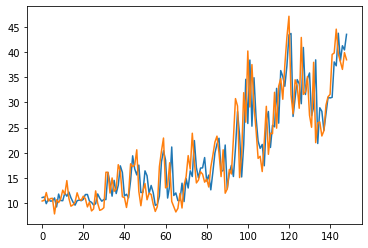

In [57]:
df_pred = plot_predictions(model,X_test,y_test)

In [60]:
cu.model_evaluate('LSTM',df_pred['Power usage Actuals'], df_pred['Power usage Predictions'])

,exp_varne,max_error,r2,mae,mse,rmse,mape
LSTM,0.776711,16.457395,0.776475,3.430461,22.399266,4.732786,0.180722


#***XGBoost***

In [78]:
comb_df

,Temp_avg,Dew_avg,Hum_max,Wind_avg,Press_max,Value (kWh)
Date,,,,,,
2016-06-01,74.8,71.4,100,9.5,29.8,29.691
2016-06-02,71.2,70.3,100,7.8,29.8,28.789
2016-06-03,72.1,70.0,100,4.7,29.8,19.247
2016-06-04,71.2,70.0,100,7.0,29.8,22.883
2016-06-05,73.8,70.0,100,7.7,29.7,25.195
...,...,...,...,...,...,...
2020-07-03,84.7,72.8,91,6.3,29.9,39.659
2020-07-04,84.6,72.9,94,3.6,29.9,38.071
2020-07-05,85.4,73.5,88,6.2,29.8,36.565


##Pre-Processing

**Since we are using XGBoost model here, which is a Multivariate model we will be using multiple feature columns and hence we need to scale them down first**

In [79]:
col_list = ['Temp_avg', 'Dew_avg', 'Wind_avg', 'Press_max', 'Hum_max']

**Based on the skewness of each column(scatter plot of each column), we decide whether to go for Normalization or Min-Max Scaling**

In [80]:
scale_list, normalise_list = cu.preprocess_numeric_column_data(comb_df[col_list])
print(scale_list)
print(normalise_list)

[]
['Temp_avg', 'Dew_avg', 'Wind_avg', 'Press_max', 'Hum_max']


**We can see that all the data needs to be normalized, meaning all of the data is skewed**

In [81]:
if len(normalise_list) > 0:
  cu.normalization(comb_df, normalise_list)
if len(scale_list) > 0:
  cu.standardization(comb_df, scale_list)

##Splittting Data

**We will be splitting the data into train, validation and test data**

In [82]:
X_train, y_train, X_valid, y_valid, X_test, y_test = tu.split_train_test_validation(comb_df, 0.15, 0.15, 'Value (kWh)')

/content/Helper_Functions/timeseries_utils.py:22: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train.drop([label], 1)
/content/Helper_Functions/timeseries_utils.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_valid = valid.drop([label], 1)
/content/Helper_Functions/timeseries_utils.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test  = test.drop([label], 1)


##Model Fitting

* We are doing hyperparameter tuning here to increase the accuracy of the model
* We are using 3 different methods to do hyperparameter tuning to compare all of them

In [83]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

param_size = ParameterGrid(parameters)
len(param_size)

256

###GridSearchCV

####**Model Fitting**

In [84]:
%%time

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.02, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.43300002459951015
CPU times: user 6min 47s, sys: 6.85 s, total: 6min 54s
Wall time: 6min 54s


In [85]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 847 ms, sys: 12.7 ms, total: 859 ms
Wall time: 863 ms


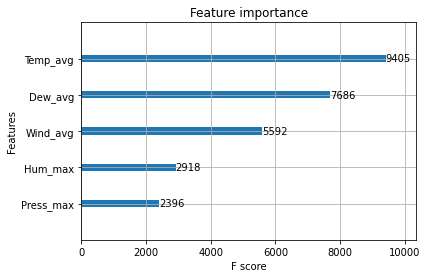

In [86]:
plot_importance(model);

####**Predictions**

In [87]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')

y_true = [10.366 12.151 10.204 11.819 11.846 10.598 11.272 10.11   8.626  9.622]
y_pred = [ 8.229904 12.310188 10.118149 15.521743  8.560138 10.404712  9.779077
  9.08609   9.99872  12.211145]


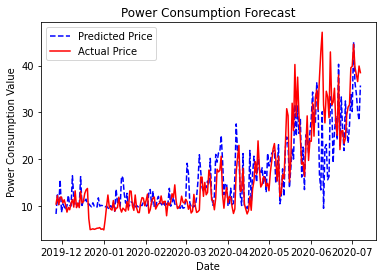

In [88]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('Power Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Power Consumption Value')
plt.legend()
plt.show()

In [89]:
cu.model_evaluate('XGBRegessor(GridSearchCV)', y_test, y_pred)

,exp_varne,max_error,r2,mae,mse,rmse,mape
XGBRegessor(GridSearchCV),0.711591,29.573524,0.711089,3.348237,26.418507,5.139894,0.231048


[###**Using GridSearchCV, we got r2 score of 0.71 and an accuracy of 77%**](https://)

###RandomSearchCV

####**Model Fitting**

In [90]:
%%time

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
random_search = RandomizedSearchCV(model,param_distributions=parameters,verbose=1, n_jobs=-1, n_iter=50)
random_result = random_search.fit(X_train, y_train)

print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score:  41.37177753601787
Best Params:  {'random_state': 42, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.02}
CPU times: user 3.72 s, sys: 209 ms, total: 3.92 s
Wall time: 1min 11s


In [91]:
%%time

model = xgb.XGBRegressor(**random_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 956 ms, sys: 11.6 ms, total: 967 ms
Wall time: 970 ms


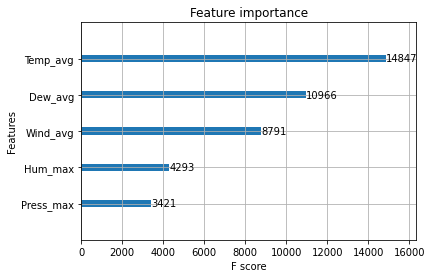

In [92]:
plot_importance(model);

####**Predictions**

In [93]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')

y_true = [10.366 12.151 10.204 11.819 11.846 10.598 11.272 10.11   8.626  9.622]
y_pred = [ 8.899162  12.805019   9.830014  15.3896055  8.6101675 10.387205
  9.783846   9.22009   10.538204  13.258001 ]


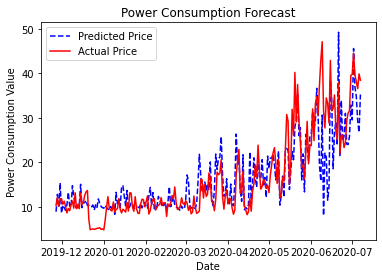

In [94]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('Power Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Power Consumption Value')
plt.legend()
plt.show()

In [95]:
cu.model_evaluate('XGBRegressor(RandomSearchCV)', y_test, y_pred)

,exp_varne,max_error,r2,mae,mse,rmse,mape
XGBRegressor(RandomSearchCV),0.702171,27.152202,0.70181,3.383391,27.26702,5.221783,0.232265


##**Using RandomSearchCV, we got r2 score of 0.70 and an accuracy of 77%**

###HyperOpt

####**Model Fitting**

In [96]:
%%time

def accuracy_model(params):
   model = xgb.XGBRegressor(**params)   
   return cross_val_score(model, X_train, y_train).mean()

param_space = {
  'n_estimators': hp.choice('n_estimators', range(100,400)), #[100, 200, 300, 400]),
  'learning_rate': hp.uniform('learning_rate', 0.001,0.05), #[0.001, 0.005, 0.01, 0.05]),
  "max_depth": 8, # hp.choice("max_depth", np.arange(8, 15, 1, dtype=int)), #[8, 10, 12, 15]),
  'gamma': hp.uniform('gamma', 0.001,0.02),  #[0.001, 0.005, 0.01, 0.02]),
  'random_state': 42
}

best = 0
def f(params):
    global best
    acc = accuracy_model(params)
    if acc > best:
       best = acc
    return {'loss': -acc, 'status': STATUS_OK}
    
Trials = Trials()
best_params = fmin(f, param_space , algo=tpe.suggest, max_evals=100, trials= Trials)

print('New best:', best, best_params)
print(best_params)

[22:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [97]:
%%time

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(**best_params, objective='reg:squarederror') #eval_set=eval_set,objective='reg:squarederror', verbose=False)
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 22.5 ms, sys: 11 µs, total: 22.5 ms
Wall time: 23.1 ms


####**Predictions**

In [98]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:10]}')
print(f'y_pred = {y_pred[:10]}')

y_true = [10.366 12.151 10.204 11.819 11.846 10.598 11.272 10.11   8.626  9.622]
y_pred = [1.4372911 1.4372911 1.7294345 2.133175  1.4372911 1.4372911 1.4372911
 1.4372911 1.4372911 1.4372911]


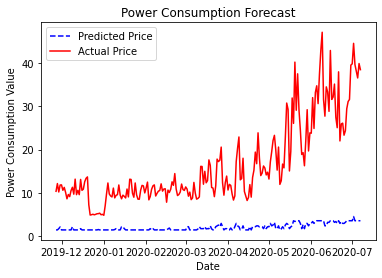

In [99]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('Power Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Power Consumption Value')
plt.legend()
plt.show()

In [100]:
cu.model_evaluate('XGBRegressor(HyperOPT)', y_test, y_pred)

,exp_varne,max_error,r2,mae,mse,rmse,mape
XGBRegressor(HyperOPT),0.1404,43.57206,-2.106292,14.333231,284.044868,16.853631,0.857825


###**Using HyperOPT, we got r2 score of -2.1(meaning not following the actual trend of data) and an accuracy of 15%**

##**Conclusion**
* Out of the three hyperparameter tuning method
  * GridSearchCV gives the highest accuracy and r2 score
  * RandomSearchCV gives similar accuracy and less r2 score but almost 5 times faster
  * HyperOPT gives not good results as expected from it
* Overall, the accuracy is lesser compared to LSTM, hence LSTM is better in this scenario

#***SARIMA***

In [ ]:
comb_df.head()

,Temp_avg,Dew_avg,Hum_max,Wind_avg,Press_max,Value (kWh)
Date,,,,,,
2016-06-01,74.8,71.4,100,9.5,29.8,29.691
2016-06-02,71.2,70.3,100,7.8,29.8,28.789
2016-06-03,72.1,70.0,100,4.7,29.8,19.247
2016-06-04,71.2,70.0,100,7.0,29.8,22.883
2016-06-05,73.8,70.0,100,7.7,29.7,25.195


##**Step 1. Plot the time series data and observe the trend and seasonality**

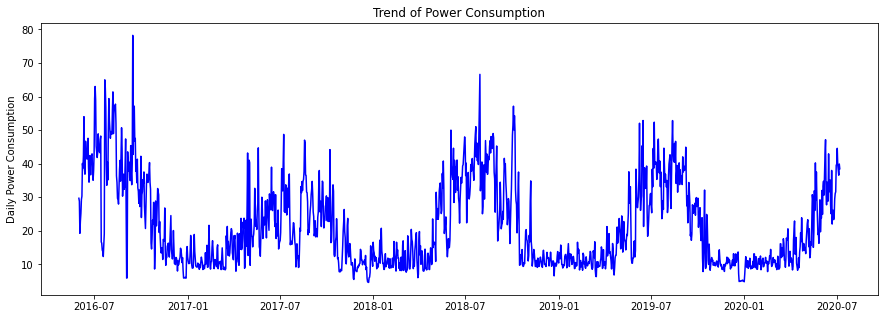

In [ ]:
plt.figure(figsize=(15,5))
plt.ylabel('Daily Power Consumption')
plt.title('Trend of Power Consumption')
plt.plot(comb_df['Value (kWh)'],'b-');

##**Step 2. Use statistical tests like ADF and KPSS to check for stationarity**

1. **Scenario I — Both tests conclude stationarity. Therefore, the series is stationary.**
2. **Scenario II — Both tests conclude non stationarity. Therefore, the series is non stationary.**
3. **Scenario III — ADF test concludes stationarity but KPSS test concludes non stationarity. This indicates that one needs to use differencing to make the series stationary. Here, a new series is created where the value of the observation at time t is given by the difference between the actual value at time t and the value at time t-1. Thus,**
4. **Scenario IV — ADF tests concludes non stationarity but KPSS test confirms stationarity. This indicates that one needs to use detrending to make the series stationary. Common methods of detrending include using log transformation, square root transformation of the original series.**

In [ ]:
tu.adf_test(comb_df['Value (kWh)'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.933948
p-value                    0.041540
# lags used               17.000000
# observations          1480.000000
critical value (1%)       -3.434776
critical value (5%)       -2.863495
critical value (10%)      -2.567811
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


*The p-value is < 0.05, thus rejecting the Null hypothesis, the data can be said to have Stationarity*

In [ ]:
tu.kpss_test(comb_df['Value (kWh)'])

Results of KPSS Test:
Test Statistic            0.350591
p-value                   0.098452
Lags Used                24.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


*The p-value is > 0.05, thus rejecting the Null hypothesis, the data can said to have stationarity*

**Overall we can conclude that the data has stationarity**

##**Step 3. If the series is not stationary, use transformations like differencing or detrending. For seasonal data, one may require seasonal differencing in addition to non seasonal differencing.**

*Since the data has stationarity we can skip this test*

###Seasonal Difference(12)

In [ ]:
comb_df['Value (kWh)_seasonaldiff'] = comb_df['Value (kWh)'] - comb_df['Value (kWh)'].shift(12)
comb_df[['Value (kWh)','Value (kWh)_seasonaldiff']].head(13)

,Value (kWh),Value (kWh)_seasonaldiff
Date,,
2016-06-01,29.691,NaN
2016-06-02,28.789,NaN
2016-06-03,19.247,NaN
2016-06-04,22.883,NaN
2016-06-05,25.195,NaN
2016-06-06,29.323,NaN
2016-06-07,30.322,NaN
2016-06-08,40.051,NaN
2016-06-09,38.667,NaN


In [ ]:
tu.adf_test(comb_df['Value (kWh)_seasonaldiff'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.668140e+00
p-value                 4.624099e-14
# lags used             2.400000e+01
# observations          1.461000e+03
critical value (1%)    -3.434834e+00
critical value (5%)    -2.863520e+00
critical value (10%)   -2.567824e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
tu.kpss_test(comb_df['Value (kWh)_seasonaldiff'].dropna())

Results of KPSS Test:
Test Statistic            0.084899
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


**Once again we can see that the data after Seasonal differencing has Stationarity**

###Normal Differencing(1)

In [ ]:
comb_df['Value (kWh)_diff'] = comb_df['Value (kWh)_seasonaldiff'] - comb_df['Value (kWh)_seasonaldiff'].shift(1)
# comb_df[['Value (kWh)','Value (kWh)_seasonaldiff', 'Value (kWh)_diff']].head(14)

In [ ]:
tu.adf_test(comb_df['Value (kWh)_diff'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.449011e+01
p-value                 6.168331e-27
# lags used             2.400000e+01
# observations          1.460000e+03
critical value (1%)    -3.434837e+00
critical value (5%)    -2.863522e+00
critical value (10%)   -2.567825e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
tu.kpss_test(comb_df['Value (kWh)_diff'].dropna())

Results of KPSS Test:
Test Statistic            0.055595
p-value                   0.100000
Lags Used                85.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


**Once again we can see that the data after Normal differencing has Stationarity**

##**Step 4. Once the order of differencing is determined, we need to decide on the optimal AR and MA terms.**

***We can conclude that the series is non stationary. If we plot the ACF and PACF plots of the differenced series, we can see strong positive autocorrelation between the initial lags.***

###*Without any differencing*

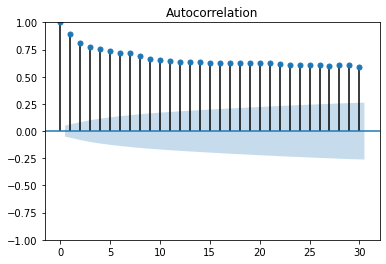

In [ ]:
acf_plot = plot_acf(comb_df['Value (kWh)'], lags= 30)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


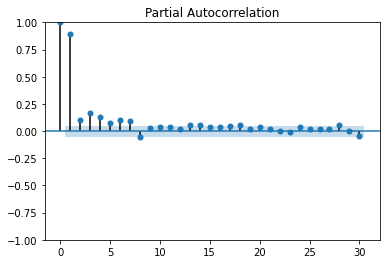

In [ ]:
pacf_plot = plot_pacf(comb_df['Value (kWh)'], lags= 30)

###*After Seasonal Differencing*

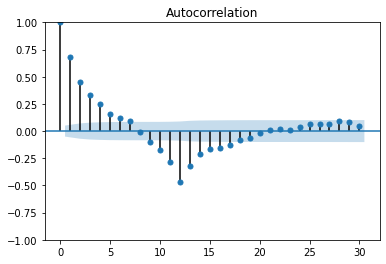

In [ ]:
acf_plot = plot_acf(comb_df['Value (kWh)_seasonaldiff'].dropna(), lags= 30)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


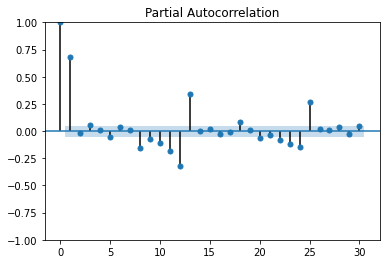

In [ ]:
pacf_plot = plot_pacf(comb_df['Value (kWh)_seasonaldiff'].dropna(), lags= 30)

###*After another normal differencing*

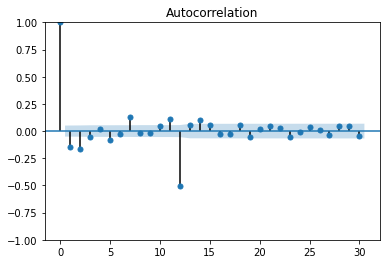

In [ ]:
acf_plot = plot_acf(comb_df['Value (kWh)_diff'].dropna(), lags= 30)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


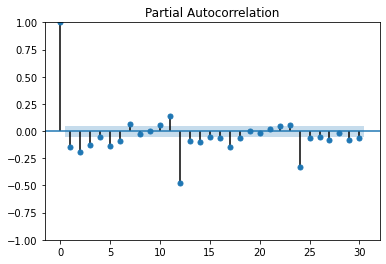

In [ ]:
pacf_plot = plot_pacf(comb_df['Value (kWh)_diff'].dropna(), lags= 30)

###*Plotting after all the Differencing*

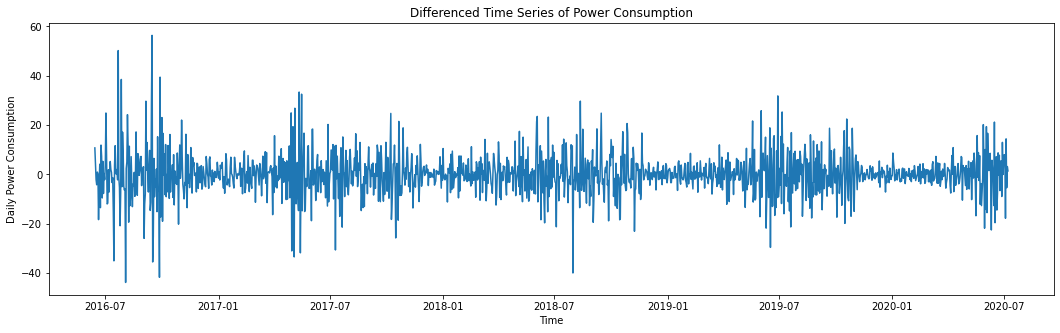

In [ ]:
plt.figure(figsize=(18,5));
plt.xlabel('Time');
plt.ylabel('Daily Power Consumption');
plt.title('Differenced Time Series of Power Consumption');
plt.plot(comb_df['Value (kWh)_diff']);

##**Step 5. Use the ACF and PACF plots to get a range within which the parameters p,P,q,Q should lie. Use auto.arima and specify the range of these parameters.**

1. So far, we have used differencing twice i.e. one seasonal differencing of order D=1, and one non seasonal differencing of order d=1.
2. The next step is to determine the AR and MA parameters. In the PACF plot, there is a significant negative lag at 1 and at 12 and 24.
3. Thus, the AR parameter should be 1 and seasonal AR parameter should be 2.
4. Given there is a negative lag at 1 and 12 for ACF plot as well, as per the guidelines, we will not include MA and seasonal MA terms.

**Thus, the final order of the model seems to be (1,1,0)(2,1,0)12.**

In [ ]:
comb_df

,Temp_avg,Dew_avg,Hum_max,Wind_avg,Press_max,Value (kWh),Value (kWh)_seasonaldiff,Value (kWh)_diff
Date,,,,,,,,
2016-06-01,74.8,71.4,100,9.5,29.8,29.691,NaN,NaN
2016-06-02,71.2,70.3,100,7.8,29.8,28.789,NaN,NaN
2016-06-03,72.1,70.0,100,4.7,29.8,19.247,NaN,NaN
2016-06-04,71.2,70.0,100,7.0,29.8,22.883,NaN,NaN
2016-06-05,73.8,70.0,100,7.7,29.7,25.195,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-07-03,84.7,72.8,91,6.3,29.9,39.659,1.680,-17.822
2020-07-04,84.6,72.9,94,3.6,29.9,38.071,16.066,14.386
2020-07-05,85.4,73.5,88,6.2,29.8,36.565,10.618,-5.448


In [ ]:
df = comb_df['Value (kWh)']

In [ ]:
model = auto_arima(df, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=10588.156, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=10114.121, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=10556.648, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=9911.173, Time=1.34 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.17 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=9941.580, Time=1.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=9855.420, Time=1.86 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=10055.090, Time=0.96 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=14.17 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.99 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=9715.069, Time=5.32 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=9911.433, Time=3.56 sec
 ARIMA(2,1,1)(2,1,1)[12]             : 

**Auto Arima gives (1,1,1)(2,1,0)12 as the best model i.e. the model with the least AIC.**

In [ ]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1498
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -4852.235
Date:                             Tue, 21 Jun 2022   AIC                           9714.470
Time:                                     07:27:08   BIC                           9740.986
Sample:                                          0   HQIC                          9724.353
                                            - 1498                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6552      0.016     41.390      0.000       0.624       0.686
ma.L1         -0.9667      

**The coefficients of AR and MA terms is less than 1 , the sum of the coefficients of the two seasonal AR terms is less than one and the sum of the coefficients of two MA terms is also less than one. Each of these terms are significant with p value less than 0.05. This seems to be a good model. Thus, a SARIMA model (1,1,1) (2,1,0)12 is the final selected model. (This is close to model (1,1,0)(2,1,0) 12 that we identified from the plots)**

##**Step 6. Check for the assumptions of the regression model i.e. normality of errors and no autocorrelation between the errors.**

###*Splitting Data*

In [ ]:
train, test = tu.split_train_test(comb_df['Value (kWh)'], 0.05)

###*Model 1 (No Exogenous Variables)*

####*Fitting Model*

In [ ]:
final_model = SARIMAX(train,order=(1,1,1),seasonal_order=(2,1,0,12))
result = final_model.fit()
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Value (kWh)   No. Observations:                 1423
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -4604.013
Date:                             Tue, 21 Jun 2022   AIC                           9218.026
Time:                                     07:27:28   BIC                           9244.283
Sample:                                 06-01-2016   HQIC                          9227.838
                                      - 04-23-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6608      0.016     41.482      0.000       0.630       0.692
ma.L1         -0.9676      

**If the errors are normally distributed and are uncorrelated to each other, then we actually have a good model.**

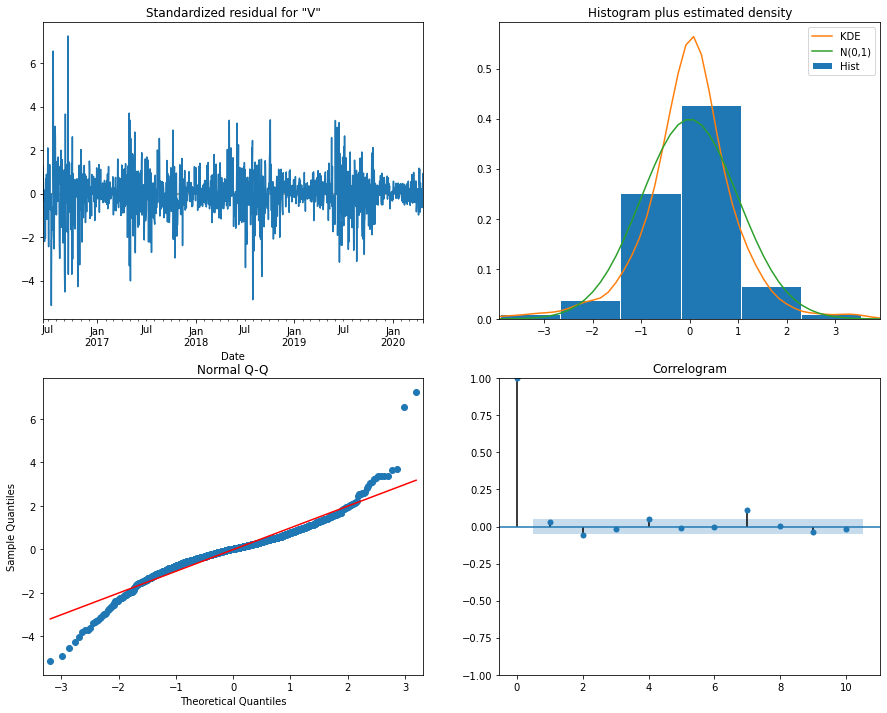

In [ ]:
result.plot_diagnostics(figsize=(15, 12));

**We can see here that the residuals are white noise and they are also normally distributed. We can thus go ahead with this model.**

####*Predicitons*

[Text(0, 0.5, 'Power Consumption'), Text(0.5, 0, 'Date')]

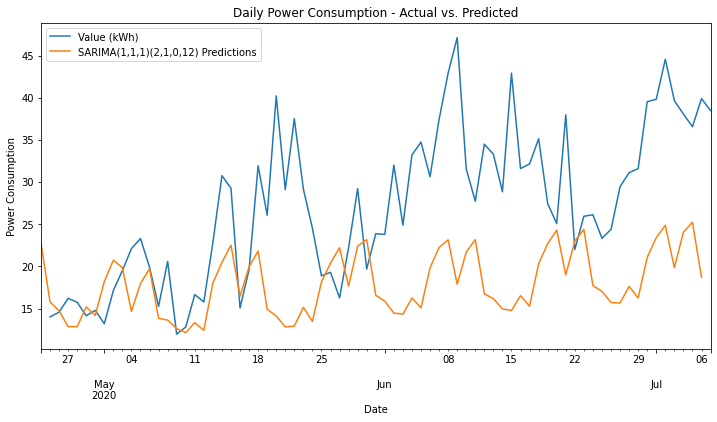

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(2,1,0,12) Predictions')
# Plot predictions against known values
title = 'Daily Power Consumption - Actual vs. Predicted'
ylabel='Power Consumption'
xlabel='Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
cu.model_evaluate('SARIMA(1,1,1)(2,1,0,12)',test, predictions)

,exp_varne,max_error,r2,mae,mse,rmse,mape
"SARIMA(1,1,1)(2,1,0,12)",0.089923,27.963236,-0.953297,10.096116,157.563183,12.552417,0.329511


*R2 is negative only when the chosen model does not follow the trend of the data. It seems that your model may be giving better performance because of over-fitting.*

###*Model 2 (Without Exogenous Variables),model suggested by acf & pacf plot*

In [ ]:
final_model = SARIMAX(train,order=(1,1,1),seasonal_order=(0,1,0,12))
result = final_model.fit()
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Value (kWh)   No. Observations:                 1423
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood               -4897.617
Date:                             Tue, 21 Jun 2022   AIC                           9801.233
Time:                                     07:31:19   BIC                           9816.987
Sample:                                 06-01-2016   HQIC                          9807.121
                                      - 04-23-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6845      0.013     52.403      0.000       0.659       0.710
ma.L1         -0.9997      

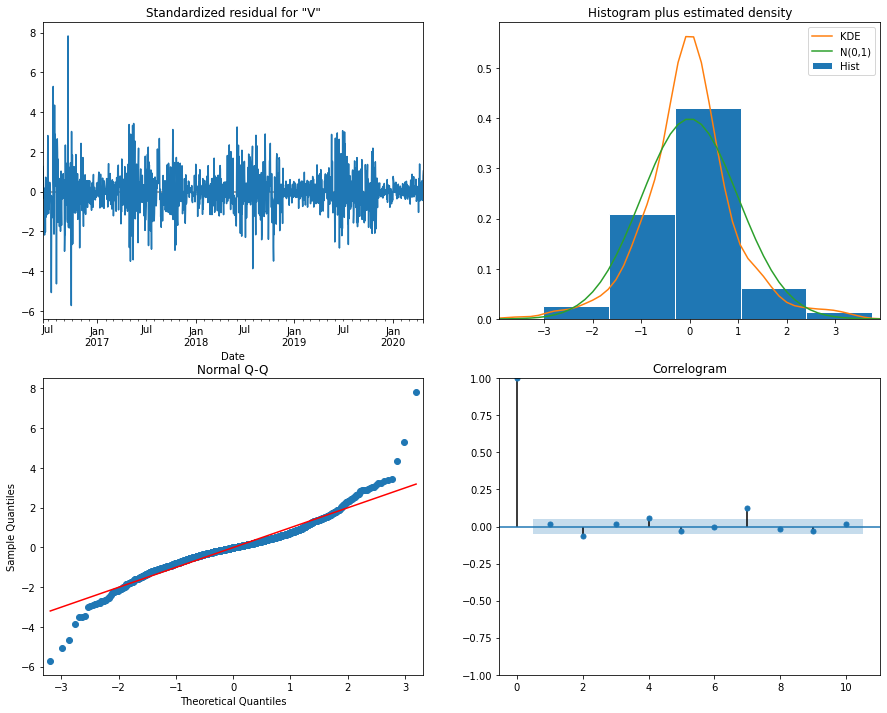

In [ ]:
result.plot_diagnostics(figsize=(15, 12));

[Text(0, 0.5, 'Power Consumption'), Text(0.5, 0, 'Date')]

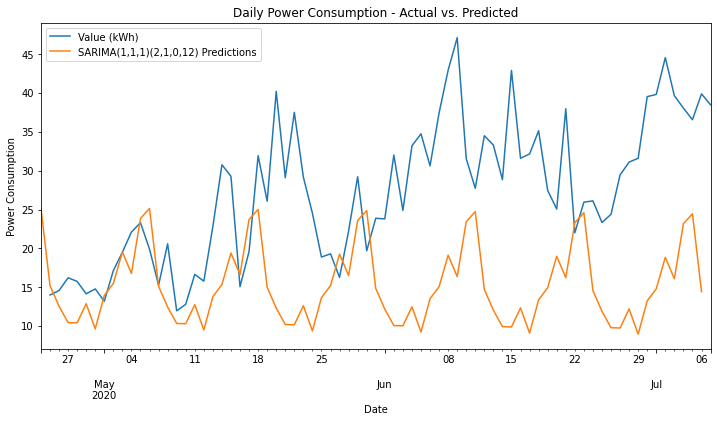

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,1)(2,1,0,12) Predictions')
# Plot predictions against known values
title = 'Daily Power Consumption - Actual vs. Predicted'
ylabel='Power Consumption'
xlabel='Date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
cu.model_evaluate('SARIMA(1,1,1)(2,1,0,12)',test, predictions)

,exp_varne,max_error,r2,mae,mse,rmse,mape
"SARIMA(1,1,1)(2,1,0,12)",-0.308366,32.995039,-2.053697,12.821678,246.327261,15.694816,0.426157
